In [1]:
import os
import ast
import math
import json
import torch
import openai
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from langchain.embeddings import OpenAIEmbeddings
from transformers import BertTokenizer, BertModel
from get_embedding import getEmbeddingDict


/opt/homebrew/Caskroom/miniforge/base/envs/cq1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import tensorflow as tf
from transformers import GPT2Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load your data here
book_df = pd.read_excel('Book.xlsx')
book_test_df = pd.read_excel('Book_test.xlsx')

# Assume book_df has columns 'tags_emotion' and 'label'
texts = book_df['tags_emotion'].values
labels = book_df['label'].values

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Tokenize the text
sequences = [tokenizer.encode(text, add_special_tokens=True) for text in texts]

# Pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y = tf.keras.utils.to_categorical(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RNN model
vocab_size = tokenizer.vocab_size
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length))
model.add(SimpleRNN(units=64, return_sequences=False))
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))


model.save('model.h5')


Epoch 1/30
3/3 [==============================] - 1s 70ms/step - loss: 2.2891 - accuracy: 0.0989 - val_loss: 2.2653 - val_accuracy: 0.0435
Epoch 2/30
3/3 [==============================] - 0s 14ms/step - loss: 2.1570 - accuracy: 0.3736 - val_loss: 2.1860 - val_accuracy: 0.2609
Epoch 3/30
3/3 [==============================] - 0s 15ms/step - loss: 2.0284 - accuracy: 0.4945 - val_loss: 2.0966 - val_accuracy: 0.3478
Epoch 4/30
3/3 [==============================] - 0s 15ms/step - loss: 1.8850 - accuracy: 0.4945 - val_loss: 1.9972 - val_accuracy: 0.3478
Epoch 5/30
3/3 [==============================] - 0s 17ms/step - loss: 1.7534 - accuracy: 0.5055 - val_loss: 1.9117 - val_accuracy: 0.3478
Epoch 6/30
3/3 [==============================] - 0s 16ms/step - loss: 1.6286 - accuracy: 0.5385 - val_loss: 1.8621 - val_accuracy: 0.3478
Epoch 7/30
3/3 [==============================] - 0s 15ms/step - loss: 1.5109 - accuracy: 0.5385 - val_loss: 1.8508 - val_accuracy: 0.3913
Epoch 8/30
3/3 [===========

In [16]:
import numpy as np

# Tokenize and pad the "Book_test" data
test_sequences = [tokenizer.encode(text, add_special_tokens=True) for text in book_test_df['tags_emotion'].values]
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Make predictions
predictions = model.predict(X_test)

# Convert the probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert the integer class labels to original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Add the predicted labels to the test dataframe
book_test_df['predicted_label'] = predicted_labels

# Display the test dataframe with the predicted labels
book_test_df


6/6 [==============================] - 0s 1ms/step


,tags_emotion,predicted_label
0,压迫,5
1,压抑,5
2,残忍,5
3,残暴,5
4,兴奋,2
...,...,...
187,喜欢,2
188,开心,2
189,沉闷,2
190,寻找,9


In [17]:
diction = {1:'搞笑组', 2:'情绪组', 3:'害怕组', 4:'正能量组', 5:'负能量组', 6:'烂片组', 7:'题材', 8:'主角路线', 9:'励志组', 10:'荒诞组', 11:'思考组', 12:'经典组'}

df = book_test_df.sort_values('predicted_label')
df['predicted_label'] = df['predicted_label'].map(diction)
df = df[['tags_emotion', 'predicted_label']]
df.to_excel('Book_output.xlsx')

In [123]:
book_test_df.sort_values('predicted_label').head(50)

,tags_emotion,predicted_label
128,幽默,1
29,幸福,2
45,欢乐,2
118,轻松,2
44,欢笑,2
80,温馨,2
28,感人,2
4,兴奋,2
97,喜悦,2
188,开心,2


In [ ]:
from langchain.embeddings import OpenAIEmbeddings
embedding = OpenAIEmbeddings(
    deployment = "embedding-ada-002-2",
    model = "text-embedding-ada-002",
    openai_api_key = "xxx",
    openai_api_base = 'https://xxxtcl-ai.openai.azure.com/',
    openai_api_type = 'azure',
    openai_api_version = '2023-07-01-preview',
    chunk_size=1,
)

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load your data
book_df = pd.read_excel('Book.xlsx')
book_test_df = pd.read_excel('Book_test.xlsx')

# Preprocess and prepare the dataset
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(book_df['tags_emotion'])

sequences = tokenizer.texts_to_sequences(book_df['tags_emotion'])
sequences_test = tokenizer.texts_to_sequences(book_test_df['tags_emotion'])

max_sequence_length = max(max(len(seq) for seq in sequences + sequences_test), max(filter_sizes))


# Custom pad_sequences function
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) == 0:  # Check for empty sequences
            continue  # Skip padding for this sequence, it's already all zeros
        if len(seq) > maxlen:
            padded_sequences[i, :] = seq[:maxlen]
        else:
            padded_sequences[i, -len(seq):] = seq
    return padded_sequences


padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(book_df['label'])
labels_one_hot = np.eye(len(set(encoded_labels)))[encoded_labels]

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels_one_hot, test_size=0.2, random_state=42)


# Define a simple CNN model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels=1,
                                              out_channels=n_filters,
                                              kernel_size=(fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
n_filters = 100
filter_sizes = [2, 3, 4]
output_dim = len(set(encoded_labels))
dropout = 0.5
weight_decay = 1e-4  # Regularization

model = TextCNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout)

# Training parameters
batch_size = 32
epochs = 15
lr = 0.0001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


# Create data loaders
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.X[idx]), torch.FloatTensor(self.y[idx])

train_data = TextDataset(X_train, y_train)
val_data = TextDataset(X_val, y_val)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

E, T, V = [], [], []

# Training loop
for epoch in range(epochs):
    model.train()
    for texts, labels in train_loader:
        predictions = model(texts)
        loss = criterion(predictions, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate after each epoch
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            predictions = model(texts)
            loss = criterion(predictions, labels)
            val_loss += loss.item()

    E.append(epoch+1)
    T.append(loss.item())
    V.append(val_loss/len(val_loader))

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}')


Epoch: 1, Training Loss: 2.3660404682159424, Validation Loss: 2.3660404682159424
Epoch: 2, Training Loss: 2.2802655696868896, Validation Loss: 2.2802655696868896
Epoch: 3, Training Loss: 2.2044875621795654, Validation Loss: 2.2044875621795654
Epoch: 4, Training Loss: 2.1367127895355225, Validation Loss: 2.1367127895355225
Epoch: 5, Training Loss: 2.0776631832122803, Validation Loss: 2.0776631832122803
Epoch: 6, Training Loss: 2.0273358821868896, Validation Loss: 2.0273358821868896
Epoch: 7, Training Loss: 1.9861234426498413, Validation Loss: 1.9861234426498413
Epoch: 8, Training Loss: 1.9527579545974731, Validation Loss: 1.9527579545974731
Epoch: 9, Training Loss: 1.9269064664840698, Validation Loss: 1.9269064664840698
Epoch: 10, Training Loss: 1.9103070497512817, Validation Loss: 1.9103070497512817
Epoch: 11, Training Loss: 1.8979038000106812, Validation Loss: 1.8979038000106812
Epoch: 12, Training Loss: 1.8897784948349, Validation Loss: 1.8897784948349
Epoch: 13, Training Loss: 1.885

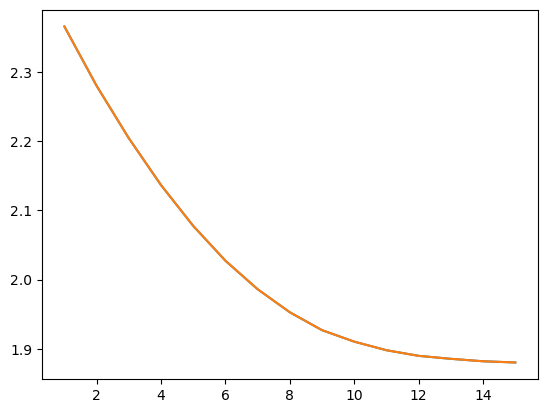

In [39]:
plt.plot(E, T)
plt.plot(E, V)
plt.show()

In [40]:
# Convert the padded_sequences_test to a PyTorch tensor
X_test = torch.tensor(padded_sequences_test, dtype=torch.long)

# Set the model to evaluation mode
model.eval()

# Predict the labels for the test data
with torch.no_grad():
    # Forward pass, get logit predictions
    logits_test = model(X_test)

    # Apply softmax to convert logits to probabilities
    probabilities_test = torch.nn.functional.softmax(logits_test, dim=1)

    # Get the predicted class labels
    _, predicted_indices = torch.max(probabilities_test, dim=1)
    predicted_labels = label_encoder.inverse_transform(predicted_indices.numpy())

predicted_labels

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [51]:
for i in b:
    if i not in a:
        print(i)

抑郁
友爱
欢乐
感动
腐败
无助
自省
复仇


In [64]:
book_test[book_test['tags_emotion'] == '奋斗']

,tags_emotion,predicted_label
26,奋斗,4


In [85]:
tuple_pca_embedding_dict = {k: tuple(v) for k, v in diction.items()}
inverse_pca_embedding_dict = {v: k for k, v in tuple_pca_embedding_dict.items()}
book_test_df['predicted_label'] = book_test_df['predicted_label'].apply(lambda x: inverse_pca_embedding_dict[tuple(x)] if tuple(x) in inverse_pca_embedding_dict else None)
book_test_df = book_test_df[['tags_emotion', 'predicted_label']]

In [97]:
diction = {1:'搞笑组', 2:'情绪组', 3:'害怕组', 4:'正能量组', 5:'负能量组', 6:'烂片组', 7:'题材', 8:'主角路线', 9:'励志组', 10:'荒诞组', 11:'思考组', 12:'经典组'}

df = book_test_df.sort_values('predicted_label')
df['predicted_label'] = df['predicted_label'].map(diction)
df = df[['tags_emotion', 'predicted_label']]
df

,tags_emotion,predicted_label
128,幽默,搞笑组
80,温馨,情绪组
188,开心,情绪组
44,欢笑,情绪组
4,兴奋,情绪组
...,...,...
66,震撼,荒诞组
12,疑惑,思考组
83,自省,思考组
101,遗憾,思考组


In [98]:
df.to_excel('Book_output.xlsx')

In [93]:
# Train the model, capturing the history
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# The history object now contains the records of loss and accuracy for each epoch
print(history.history)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# # plt.legend(['Train'], loc='upper left')
# # plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



Epoch 1/50


4/4 [==============================] - 0s 12ms/step - loss: 0.0245 - accuracy: 0.9832 - val_loss: 2.2969 - val_accuracy: 0.2333
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9748 - val_loss: 2.2967 - val_accuracy: 0.2333
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0246 - accuracy: 0.9748 - val_loss: 2.2968 - val_accuracy: 0.2333
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.9832 - val_loss: 2.2972 - val_accuracy: 0.2333
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 0.9832 - val_loss: 2.2971 - val_accuracy: 0.2333
Epoch 6/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9748 - val_loss: 2.2974 - val_accuracy: 0.2333
Epoch 7/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9832 - val_loss: 2.2974 - val_accuracy: 0.2333
Epoch 8/50
4/4 [============================

TypeError: unsupported operand type(s) for -: 'list' and 'list'